In [1]:
import numpy as np
import time
import os
import matplotlib.pyplot as plt 
from Queue import PriorityQueue
import planners
reload(planners)

<module 'planners' from 'c:\Users\herbi\Documents\Spring 2022\6141\racecar_docker\home\racecar_ws\src\path_planning\src\planners.pyc'>

In [32]:
occupancy_grid_ex_1 = np.reshape(np.array([
    [0,0,0,0,0,100,0,0,0,0],
    [0,0,0,0,0,100,0,0,0,0],
    [0,0,100,0,0,100,0,0,0,0],
    [0,0,100,0,0,100,0,0,0,0],
    [0,0,100,0,0,100,0,0,0,0],
    [0,0,100,0,0,0,0,0,0,0],
    [0,0,100,0,0,0,0,0,0,0],
    [0,0,100,0,0,0,0,0,0,0],
    [0,0,100,0,0,0,0,100,0,0],
    [0,0,100,0,0,0,0,100,0,0]
    ]).flatten('A'), (10,10))
occupancy_grid_ex_2 = np.reshape(np.array([
    [0,0,0,0,0,100,0,0,0,0,0,0,0,0,100,0,0,0,0,0,100,0,0,0,0],
    [0,0,0,0,0,100,0,0,0,0,0,0,0,0,100,0,0,0,0,0,100,0,0,0,0],
    [0,0,100,0,0,100,0,0,0,0,0,0,0,0,100,0,0,0,0,0,100,0,0,0,0],
    [0,0,100,0,0,100,0,0,0,0,0,0,0,0,100,0,0,0,0,0,100,0,0,0,0],
    [0,0,100,0,0,100,0,0,0,0,0,0,0,0,100,0,0,0,0,0,100,0,0,0,0],
    [0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,100,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,100,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,100,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0],
    [0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0],
    [0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0],
    [0,0,100,0,0,0,0,100,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0],
    [0,0,100,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,100,0,0,100,0,0,0,0,0,0,0,0,100,0,0,0,0,0,100,0,0,0,0],
    [0,0,100,0,0,100,0,0,0,0,0,0,0,0,100,0,0,0,0,0,100,0,0,0,0],
    [0,0,100,0,0,100,0,0,0,0,0,0,0,0,100,0,0,0,0,0,100,0,0,0,0],
    [0,0,100,0,0,100,0,0,0,0,0,0,0,0,100,0,0,0,0,0,100,0,0,0,0],
    [0,0,100,0,0,100,0,0,0,0,0,0,0,0,100,0,0,0,0,0,100,0,0,0,0],
    ]).flatten('A'), (25,25))

In [2]:
REDUCTION_FACTOR = 2 

def reduce_map(occupancy_grid):
    """
    Reduces the resolution of the map by a factor of REDUCTION_FACTOR
    """
    new_grid = np.zeros(
        (occupancy_grid.shape[0]/REDUCTION_FACTOR, occupancy_grid.shape[1]/REDUCTION_FACTOR))
    for i in range(occupancy_grid.shape[0]/REDUCTION_FACTOR):
        for j in range(occupancy_grid.shape[1]/REDUCTION_FACTOR):
            new_grid[i][j] = np.max(occupancy_grid[i*REDUCTION_FACTOR:(
                i+1)*REDUCTION_FACTOR, j*REDUCTION_FACTOR:(j+1)*REDUCTION_FACTOR])
    return new_grid

def plan_path(map,planner, start, goal, visualize=True):
    planner = planner(map,map.shape[0],map.shape[1],1,1)
    path = planner.find_path(start, goal)
    if visualize:
        plt.figure()
        map[start] = 2
        map[goal] = 3
        plt.imshow(map)
        plt.figure()
        for point in path:
            point = (int(point[1]),int(point[0]))
            if map[point] == 0:
                map[point] = 40
            else:
                map[point] = 50
        plt.imshow(map)
        plt.show()
    return path



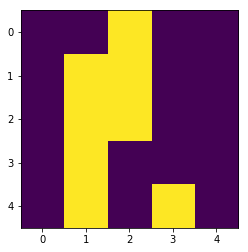

In [49]:
plt.imshow(reduce_map(occupancy_grid_ex_1.copy()))

Found goal state!


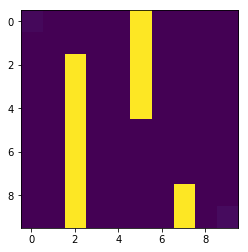

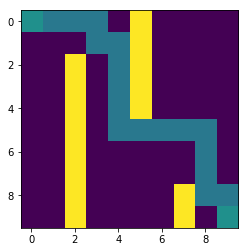

Break!


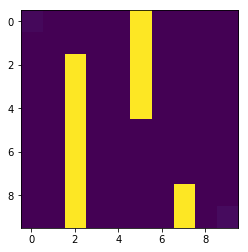

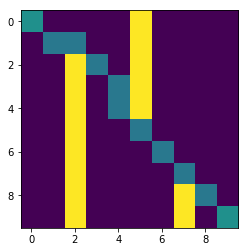

Found goal state!


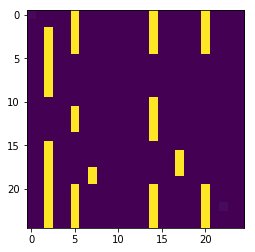

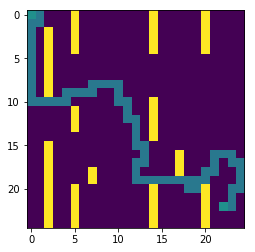

Break!


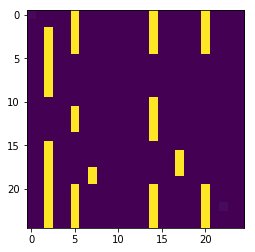

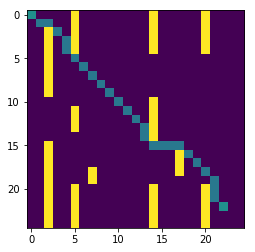

[(0, 0),
 (1, 1),
 (2, 1),
 (3, 2),
 (4, 3),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 7),
 (8, 8),
 (9, 9),
 (10, 10),
 (11, 11),
 (12, 12),
 (13, 13),
 (13, 14),
 (14, 15),
 (15, 15),
 (16, 15),
 (17, 15),
 (18, 16),
 (19, 17),
 (20, 18),
 (21, 19),
 (21, 20),
 (21, 21),
 (22, 22)]

In [46]:
nodes = plan_path(occupancy_grid_ex_1.copy(),planners.RRTPlanner, (0,0), (9,9), visualize=True)
nodes = plan_path(occupancy_grid_ex_1.copy(),planners.AStarPlanner, (0,0), (9,9), visualize=True)
nodes = plan_path(occupancy_grid_ex_2.copy(),planners.RRTPlanner, (0,0), (22,22), visualize=True)
# plt.scatter([node.x for node in nodes],[node.y for node in nodes])
plan_path(occupancy_grid_ex_2.copy(),planners.AStarPlanner, (0,0), (22, 22), visualize=True)

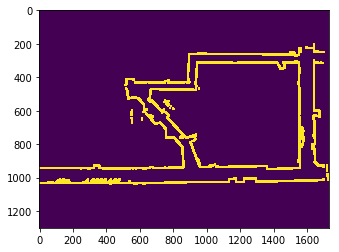

In [3]:
data = np.load('dilated_map.npy')
map = np.reshape(data, (1300, 1730))
plt.imshow(map)

In [4]:
import timeit 
import pandas as pd
test_paths = {'test1':[(51,978),(603,991)],
'test2':[(73,989),(1116,973)],
'test3':[(596,989),(899,855)],
'test4':[(762,972),(985,284)],
'test5':[(876, 982), (1590, 295)]
}
algorithms = {'RRT':planners.RRTPlanner,'AStar':planners.AStarPlanner}
time_df = pd.DataFrame(columns=['algorithm','test1','test2','test3','test4','test5'])
dist_df = pd.DataFrame(columns=['algorithm','test1','test2','test3','test4','test5']) 

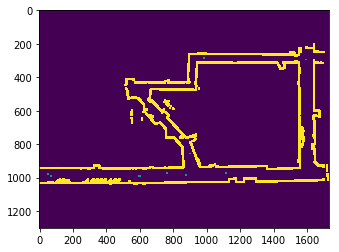

In [8]:
marked_map = map.copy()
for test in test_paths:
    for i in range(-5,6):
        for j in range(-5,6):
            for x,y in test_paths[test]:
                marked_map[(j+y, x+i)] = 50 
plt.imshow(marked_map)

In [9]:
NUM_ITERATIONS = 1
for alg in algorithms:
    planner = algorithms[alg](map,map.shape[0],map.shape[1],1)
    avg_dists = []
    time_dists = []
    for test in test_paths:
        start = test_paths[test][0]
        goal = test_paths[test][1]
        avg_dist = 0
        for i in range(NUM_ITERATIONS):
            path = planner.find_path(start, goal)
            if path is not None:
                avg_dist += sum([np.sqrt((path[i][0]-path[i+1][0])**2+(path[i][1]-path[i+1][1])**2) for i in range(len(path)-1)])
            else:
                avg_dist += np.inf
        avg_dists.append(avg_dist/NUM_ITERATIONS)
        time_dists.append(timeit.timeit(lambda:planner.find_path(start, goal),number=NUM_ITERATIONS)/NUM_ITERATIONS)
    print(alg, avg_dists, time_dists)
    time_df.append({'algorithm':alg,'test1':time_dists[0],'test2':time_dists[1],'test3':time_dists[2],'test4':time_dists[3],'test5':time_dists[4]},ignore_index=True)
    dist_df.append({'algorithm':alg,'test1':avg_dists[0],'test2':avg_dists[1],'test3':avg_dists[2],'test4':avg_dists[3],'test5':avg_dists[4]},ignore_index=True)

Break!
Break!
Break!
Break!
Break!
Break!
Break!
Break!
Break!
Break!
Found goal state!
Found goal state!
Found goal state!
Found goal state!
Found goal state!
Found goal state!


In [12]:
dist_df.head(2)
time_df.head(2)

,algorithm,test1,test2,test3,test4,test5
